<a href="https://colab.research.google.com/github/yintrigue/melanoma/blob/master/Base_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from google.colab import drive
import os

# optional: mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/w207/
!ls

/content/gdrive/My Drive/w207
melanoma


In [3]:
!pip install python-resize-image

In [4]:
import pandas as pd
import numpy as np
from pylab import *
from PIL import Image
from resizeimage import resizeimage
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Using TensorFlow backend.


In [5]:
train_csv=pd.read_csv('/content/gdrive/My Drive/Kaggle/melanoma/csv/train.csv')

Above, you'll see we're only taking data from the training datset, that is because the test dataset is not labelled so it is not of use in a supervised model.

In [6]:
malignant_df=train_csv[train_csv['benign_malignant']=='malignant'][:500]
benign_df=train_csv[train_csv['benign_malignant']=='benign'][:500]



In [7]:
malignant_df_dev=train_csv[train_csv['benign_malignant']=='malignant'][500:]
benign_df_dev=train_csv[train_csv['benign_malignant']=='benign'][500:500+len(malignant_df_dev)]

In [8]:
train_labels_mal=malignant_df['benign_malignant'].tolist()
image_names_mal=malignant_df['image_name'].tolist()
train_labels_ben=benign_df['benign_malignant'].tolist()
image_names_ben=benign_df['image_name'].tolist()

train_labels_mal_dev=malignant_df_dev['benign_malignant'].tolist()
image_names_mal_dev=malignant_df_dev['image_name'].tolist()
train_labels_ben_dev=benign_df_dev['benign_malignant'].tolist()
image_names_ben_dev=benign_df_dev['image_name'].tolist()

In [9]:
%cd /content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_100/train/

/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg_compressed/q_100/train


The following cell shows an example of resizing an image to 32x32, this was done for processing purposes.

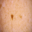

In [10]:
img=Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/ISIC_0015719.jpg")
img=img.resize((32, 32))
img

In [11]:
array(img).shape #shape of image

(32, 32, 3)

In [12]:
train_data=[]
train_labels=[]
num_mal=0
num_benign=0
for image in image_names_mal:
  try:
    im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
    im=array(im.resize((32, 32)))
    train_data.append(im)
    train_labels.append(1)
    num_mal+=1
  except:
    pass

for image in image_names_ben:
    try:
      im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image)) #"/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/{}.jpg"
      im=array(im.resize((32, 32)))
      train_data.append(im)
      train_labels.append(0)
      num_benign+=1
    except:
      pass

In [13]:
dev_data=[]
dev_labels=[]
num_mal=0
num_benign=0
for image in image_names_mal_dev:
  try:
    im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
    im=array(im.resize((32, 32)))
    dev_data.append(im)
    dev_labels.append(1)
    num_mal+=1
  except:
    pass

for image in image_names_ben_dev:
    try:
      im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
      im=array(im.resize((32, 32)))
      dev_data.append(im)
      dev_labels.append(0)
      num_benign+=1
    except:
      pass

## Basic CNN Model with Keras:

In [14]:
train_data=array(train_data)
dev_data=array(dev_data)
X_train = train_data.reshape(train_data.shape[0], 32, 32, 3)
X_dev = dev_data.reshape(dev_data.shape[0], 32, 32, 3)
X_train = X_train.astype('float32')
X_dev = X_dev.astype('float32')

X_train /= 255
X_dev /= 255

Y_train = np_utils.to_categorical(train_labels, 2)
Y_dev = np_utils.to_categorical(dev_labels, 2)

[1., 0.] indicates a benign mole

[0., 1.] indicates melanoma

In [15]:
#Sequential model
model = Sequential()

#convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))

#convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.15))

# flatten output of convolutional layer
model.add(Flatten())

# hidden layer
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(2, activation='softmax'))

# compiling sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model with data
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_dev, Y_dev))


Train on 1000 samples, validate on 168 samples
Epoch 1/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.7572 - accuracy: 0.5040 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6926 - accuracy: 0.5330 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 3/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6856 - accuracy: 0.5270 - val_loss: 0.6748 - val_accuracy: 0.6310
Epoch 4/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6749 - accuracy: 0.5740 - val_loss: 0.6595 - val_accuracy: 0.6250
Epoch 5/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6373 - accuracy: 0.6450 - val_loss: 0.6669 - val_accuracy: 0.5655
Epoch 6/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6475 - accuracy: 0.6210 - val_loss: 0.6434 - val_accuracy: 0.6310
Epoch 7/10
1000/1000 [==============================] - 11s 11ms/step - loss:

In [16]:
model.predict(X_dev)[0]

array([0.05643145, 0.9435686 ], dtype=float32)

## Basic Logistic Regression Model with Sklearn:

In [17]:
X_train_log=[]
for i in X_train:
  nsamples, nx, ny = i.shape
  d2_train_dataset = i.reshape((nsamples*nx*ny))
  X_train_log.append(d2_train_dataset)

X_dev_log=[]
for i in X_dev:
  nsamples, nx, ny = i.shape
  d2_train_dataset = i.reshape((nsamples*nx*ny))
  X_dev_log.append(d2_train_dataset)

In [18]:
log_reg=LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
log_reg.fit(X_train_log,train_labels)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In the above, 1 indicates an image of melanoma while 0 indicates an image of a benign mole.

In [19]:
prediction=log_reg.predict(X_dev_log) #predicting with dev_data
target_names=[str(x) for x in list(np.unique(dev_labels))]
print(classification_report(dev_labels, prediction, target_names=target_names)) #printing classification report to get key results

              precision    recall  f1-score   support

           0       0.73      0.68      0.70        84
           1       0.70      0.75      0.72        84

    accuracy                           0.71       168
   macro avg       0.72      0.71      0.71       168
weighted avg       0.72      0.71      0.71       168



## Basic SVM Model with Sklearn

In [20]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(X_train_log, train_labels)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [21]:
prediction_svm=svm.predict(X_dev_log) #predicting with dev_data
print(classification_report(dev_labels, prediction_svm, target_names=target_names)) #printing classification report to get key results

              precision    recall  f1-score   support

           0       0.81      0.60      0.68        84
           1       0.68      0.86      0.76        84

    accuracy                           0.73       168
   macro avg       0.74      0.73      0.72       168
weighted avg       0.74      0.73      0.72       168



In the above, 1 indicates an image of melanoma while 0 indicates an image of a benign mole.